# 1: Install Dependencies


In [1]:
# Install required packages
!pip install -q transformers datasets peft accelerate evaluate scikit-learn torch torchvision torchaudio
!pip install -q git+https://github.com/huggingface/transformers

# Clone ECG-FM repository
!git clone https://github.com/bowang-lab/ECG-FM.git
!git clone https://github.com/Jwoo5/fairseq-signals
!cd fairseq-signals
!pip install --editable ./


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

# Imports Libraries

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# ECG Dataset Class Definition

In [21]:
# ECG Dataset Wrapper for PyTorch

import torch
from torch.utils.data import Dataset


class ECGDataset(Dataset):
    """Custom PyTorch Dataset for ECG signal data."""

    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Args:
            X: Numpy array of ECG signals.
            y: Numpy array of corresponding class labels.
        """
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.long)

    def __len__(self) -> int:
        """Return the total number of samples."""
        return len(self.y)

    def __getitem__(self, index: int) -> dict:
        """Retrieve a single (signal, label) pair."""
        return {
            "signal": self.X[index],
            "label": self.y[index]
        }

def prepare_ecg_data(file_path, normalization='per_sample'):
    """
    Load ECG CSV data and return train/val/test splits.
    Assumes CSV has 'signal_0', ..., 'signal_N', 'label' columns.
    """
    df = pd.read_csv(file_path)

    # Separate features & labels
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    # Normalization
    if normalization == 'per_sample':
        X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
    elif normalization == 'global':
        X = (X - X.mean()) / (X.std() + 1e-6)

    # Train/Val/Test split (70/15/15)
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    train_end = int(0.7 * n_samples)
    val_end = int(0.85 * n_samples)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    data_splits = {
        'train': (X[train_idx], y[train_idx]),
        'val': (X[val_idx], y[val_idx]),
        'test': (X[test_idx], y[test_idx])
    }
    
    return data_splits

# CNN Feature Extractor


In [ ]:
class ECGConvExtractor(nn.Module):
    """CNN feature extractor for ECG signals."""
    
    def __init__(self, in_channels=12, conv_layers=4, conv_dim=256):
        super().__init__()
        self.conv_layers = nn.ModuleList()
        
        # First conv layer: 12 -> conv_dim
        self.conv_layers.append(
            nn.Sequential(
                nn.Conv1d(in_channels, conv_dim, kernel_size=2, stride=2),
                nn.Dropout(0.0),
                nn.GroupNorm(conv_dim, conv_dim),
                nn.GELU()
            )
        )
        
        # Remaining conv layers: conv_dim -> conv_dim
        for _ in range(1, conv_layers):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv1d(conv_dim, conv_dim, kernel_size=2, stride=2),
                    nn.Dropout(0.0),
                    nn.GELU()
                )
            )

    def forward(self, x):
        for conv in self.conv_layers:
            x = conv(x)
        return x  # shape: (batch, conv_dim, seq_len)


# Transformer Encoder Layer


In [ ]:
class ECGTransformerLayer(nn.Module):
    """Single transformer encoder layer for ECG-FM."""
    
    def __init__(self, d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.self_attn_norm = nn.LayerNorm(d_model)

        self.fc1 = nn.Linear(d_model, dim_feedforward)
        self.fc2 = nn.Linear(dim_feedforward, d_model)
        self.final_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x, attention_mask=None):
        # Self-attention
        residual = x
        x, _ = self.self_attn(x, x, x, attn_mask=attention_mask)
        x = self.dropout(x) + residual
        x = self.self_attn_norm(x)
        
        # Feedforward
        residual = x
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = residual + x
        x = self.final_norm(x)
        return x


# ECG-FM Core Model

In [ ]:
class ECGFMCore(nn.Module):
    """Core ECG-FM encoder with CNN + Transformer layers."""
    
    def __init__(
        self,
        in_channels=12,
        encoder_layers=12,
        encoder_embed_dim=768,
        encoder_ffn_dim=3072,
        attention_heads=12,
        dropout=0.1,
        conv_layers=4,
        conv_dim=256
    ):
        super().__init__()
        # CNN feature extractor
        self.feature_extractor = ECGConvExtractor(in_channels, conv_layers, conv_dim)
        self.layer_norm = nn.LayerNorm(conv_dim)
        self.proj = nn.Linear(conv_dim, encoder_embed_dim)
        
        # Positional convolution
        self.conv_pos = nn.Sequential(
            nn.Conv1d(encoder_embed_dim, encoder_embed_dim, kernel_size=128, padding=64, groups=16),
            nn.GELU()
        )
        
        self.mask_emb = nn.Parameter(torch.zeros(encoder_embed_dim))
        
        # Transformer encoder layers
        self.encoder = nn.ModuleList([
            ECGTransformerLayer(d_model=encoder_embed_dim, nhead=attention_heads, dim_feedforward=encoder_ffn_dim, dropout=dropout)
            for _ in range(encoder_layers)
        ])
        self.encoder_norm = nn.LayerNorm(encoder_embed_dim)
        
        self.final_proj = nn.Linear(encoder_embed_dim, conv_dim)
        self.dropout_input = nn.Dropout(dropout)
        self.dropout_features = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        features = self.feature_extractor(x)              # (batch, conv_dim, seq_len)
        features = features.transpose(1, 2)               # (batch, seq_len, conv_dim)
        features = self.layer_norm(features)
        features = self.dropout_features(features)
        features = self.proj(features)                    # (batch, seq_len, embed_dim)

        # Positional encoding via conv
        x_conv = features.transpose(1, 2)                 # (batch, embed_dim, seq_len)
        x_conv = self.conv_pos(x_conv)
        x_conv = x_conv.transpose(1, 2)
        
        # Match sequence lengths
        if x_conv.size(1) != features.size(1):
            if x_conv.size(1) > features.size(1):
                x_conv = x_conv[:, :features.size(1), :]
            else:
                padding = features.size(1) - x_conv.size(1)
                x_conv = F.pad(x_conv, (0, 0, 0, padding))
        
        features = features + x_conv
        features = self.dropout_input(features)

        # Transformer layers
        for layer in self.encoder:
            features = layer(features, mask)
        
        features = self.encoder_norm(features)
        return features


# ECG-FM Classifier

In [ ]:
class ECGFMClassifier(nn.Module):
    """ECG-FM with classification head."""
    
    def __init__(self, num_classes=2, freeze_encoder=False):
        super().__init__()
        self.encoder = ECGFMCore()
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # PEFT-compatible config
        class ModelConfig(dict):
            def __init__(self, **kwargs):
                super().__init__(**kwargs)
                self.__dict__ = self

        self.config = ModelConfig(
            hidden_size=768,
            num_labels=num_classes,
            problem_type="single_label_classification",
            tie_word_embeddings=False,
            is_encoder_decoder=False,
            use_return_dict=False,
            output_hidden_states=False,
            output_attentions=False,
            model_type="ecg_fm"
        )

    def forward(self, input_ids=None, signals=None, **kwargs):
        x = input_ids if input_ids is not None else signals
        if isinstance(x, dict):
            x = x.get('input_ids', x.get('signals'))

        if x.dim() == 2:
            x = x.unsqueeze(1).repeat(1, 12, 1)  # single-lead -> 12-lead

        features = self.encoder(x)
        features = features.transpose(1, 2)
        features = self.pooling(features).squeeze(-1)
        logits = self.classifier(features)
        return logits


# Pretrained Weight Loader

In [ ]:
def load_ecgfm_weights(model, checkpoint_path):
    """Load pretrained ECG-FM weights."""
    print("Loading ECG-FM pretrained checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    pretrained_dict = checkpoint['model']
    model_dict = model.encoder.state_dict()

    loaded_keys, missing_keys, skipped_keys = [], [], []
    new_dict = {}

    for key, value in pretrained_dict.items():
        if any(skip in key for skip in ['quantizer', 'project_q']):
            skipped_keys.append(key)
            continue
        if 'self_attn' in key and ('q_proj' in key or 'k_proj' in key or 'v_proj' in key):
            continue
        if key.startswith('encoder.layers.'):
            parts = key.split('.')
            layer_num = parts[2]
            rest = '.'.join(parts[3:])
            new_key = f'encoder.{layer_num}.{rest}'
            if new_key in model_dict:
                new_dict[new_key] = value
                loaded_keys.append(key)
        elif key == 'encoder.layer_norm.weight':
            new_dict['encoder_norm.weight'] = value
            loaded_keys.append(key)
        elif key == 'encoder.layer_norm.bias':
            new_dict['encoder_norm.bias'] = value
            loaded_keys.append(key)
        elif key in model_dict:
            new_dict[key] = value
            loaded_keys.append(key)
        else:
            skipped_keys.append(key)

    # Handle attention q/k/v projections
    for layer_idx in range(12):
        q_w = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.q_proj.weight')
        k_w = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.k_proj.weight')
        v_w = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.v_proj.weight')
        q_b = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.q_proj.bias')
        k_b = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.k_proj.bias')
        v_b = pretrained_dict.get(f'encoder.layers.{layer_idx}.self_attn.v_proj.bias')
        if q_w is not None and k_w is not None and v_w is not None:
            new_dict[f'encoder.{layer_idx}.self_attn.in_proj_weight'] = torch.cat([q_w, k_w, v_w], dim=0)
            loaded_keys.extend([f'encoder.layers.{layer_idx}.self_attn.{x}' for x in ['q_proj.weight','k_proj.weight','v_proj.weight']])
            if q_b is not None and k_b is not None and v_b is not None:
                new_dict[f'encoder.{layer_idx}.self_attn.in_proj_bias'] = torch.cat([q_b, k_b, v_b], dim=0)
                loaded_keys.extend([f'encoder.layers.{layer_idx}.self_attn.{x}' for x in ['q_proj.bias','k_proj.bias','v_proj.bias']])

    for key in model_dict.keys():
        if key not in new_dict:
            missing_keys.append(key)

    model.encoder.load_state_dict(new_dict, strict=False)

    print(f"✓ Loaded {len(loaded_keys)} pretrained weights, skipped {len(skipped_keys)}, missing {len(missing_keys)}")
    return model


# Data Loader & Preprocessing

In [ ]:
def load_and_preprocess_data(file_path, normalization='per_sample', test_size=0.2, val_size=0.1):
    """Load ECG data and apply normalization."""
    df = pd.read_csv(file_path)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size),
        random_state=42, stratify=y_train_val
    )

    if normalization == 'global':
        mu = X_train.mean()
        sigma = X_train.std() + 1e-8
        X_train_norm = (X_train - mu) / sigma
        X_val_norm = (X_val - mu) / sigma
        X_test_norm = (X_test - mu) / sigma
    else:
        X_train_norm = (X_train - X_train.mean(axis=1, keepdims=True)) / (X_train.std(axis=1, keepdims=True) + 1e-8)
        X_val_norm = (X_val - X_val.mean(axis=1, keepdims=True)) / (X_val.std(axis=1, keepdims=True) + 1e-8)
        X_test_norm = (X_test - X_test.mean(axis=1, keepdims=True)) / (X_test.std(axis=1, keepdims=True) + 1e-8)

    return {
        'train': (X_train_norm, y_train),
        'val': (X_val_norm, y_val),
        'test': (X_test_norm, y_test)
    }


# Adapter wrapper

In [7]:
def create_model_with_adapter(base_model, reduction_factor=16):
    """Attach trainable Adapters to a frozen base model."""

    class ModelWithAdapter(nn.Module):
        def __init__(self, base_model, adapter_size=16):
            super().__init__()
            self.base_model = base_model

            # Adapter layers (down-up projections)
            self.adapter1_down = nn.Linear(512, adapter_size)
            self.adapter1_up = nn.Linear(adapter_size, 512)

            self.adapter2_down = nn.Linear(512, adapter_size)
            self.adapter2_up = nn.Linear(adapter_size, 512)

            self.adapter3_down = nn.Linear(256, adapter_size)
            self.adapter3_up = nn.Linear(adapter_size, 256)

            self.adapter_act = nn.ReLU()

            # Freeze backbone
            for p in self.base_model.parameters():
                p.requires_grad = False

        def forward(self, input_ids=None, **kwargs):
            """Forward pass with explicit tensor checks (avoids Boolean ambiguity)."""

            # ✅ Properly handle input: don't use `or` on tensors!
            if input_ids is not None:
                x = input_ids
            elif "inputs_embeds" in kwargs and kwargs["inputs_embeds"] is not None:
                x = kwargs["inputs_embeds"]
            else:
                # fallback: grab any 2D tensor input (PEFT edge case)
                x = next((v for v in kwargs.values() if isinstance(v, torch.Tensor) and v.dim() == 2), None)

            if x is None:
                raise ValueError("No valid tensor input found for forward pass")

            # ====== Encoder Block 1 ======
            x = self.base_model.fc1(x)
            x = self.base_model.ln1(x)
            x = self.base_model.relu(x)
            x = self.base_model.dropout1(x)

            # Adapter 1
            a = self.adapter_act(self.adapter1_down(x))
            x = x + self.adapter1_up(a)

            # ====== Encoder Block 2 ======
            x = self.base_model.fc2(x)
            x = self.base_model.ln2(x)
            x = self.base_model.relu(x)
            x = self.base_model.dropout2(x)

            # Adapter 2
            a = self.adapter_act(self.adapter2_down(x))
            x = x + self.adapter2_up(a)

            # ====== Encoder Block 3 ======
            x = self.base_model.fc3(x)
            x = self.base_model.ln3(x)
            x = self.base_model.relu(x)

            # Adapter 3
            a = self.adapter_act(self.adapter3_down(x))
            x = x + self.adapter3_up(a)

            # ====== Classifier ======
            x = self.base_model.dropout_classifier(x)
            logits = self.base_model.classifier(x)

            return logits

    adapter_model = ModelWithAdapter(base_model, adapter_size=256 // reduction_factor)

    trainable_params = sum(p.numel() for p in adapter_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in adapter_model.parameters())
    print(f"Trainable params: {trainable_params:,} / {total_params:,} "
          f"({100 * trainable_params / total_params:.2f}%)")

    return adapter_model



Lora Wrapper

In [8]:
# LoRA wrapper


class LoRALinear(nn.Module):
    """Implements a LoRA layer on top of a Linear layer."""
    def __init__(self, original_linear, r=8, lora_alpha=16, lora_dropout=0.05):
        super().__init__()
        self.original_linear = original_linear
        self.r = r
        self.lora_alpha = lora_alpha
        self.scaling = lora_alpha / r
        self.dropout = nn.Dropout(lora_dropout) if lora_dropout > 0 else nn.Identity()

        in_features = original_linear.in_features
        out_features = original_linear.out_features

        # LoRA matrices
        self.lora_A = nn.Linear(in_features, r, bias=False)
        self.lora_B = nn.Linear(r, out_features, bias=False)

        # Init small
        nn.init.kaiming_uniform_(self.lora_A.weight, a=np.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

        # Freeze original weights
        for param in self.original_linear.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.original_linear(x) + self.lora_B(self.dropout(self.lora_A(x))) * self.scaling


def create_model_with_lora(base_model, r=8, lora_alpha=16, lora_dropout=0.05):
    """Wraps all Linear layers in the base model with LoRA modules."""
    for name, module in base_model.named_children():
        if isinstance(module, nn.Linear):
            setattr(base_model, name, LoRALinear(module, r, lora_alpha, lora_dropout))
        else:
            create_model_with_lora(module, r, lora_alpha, lora_dropout)  # recursion for nested modules
    return base_model


# Training + Validation Loop Functions

In [9]:
# ============================================================================
# 5️⃣ Training / Evaluation
# ============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Training"):
        signals = batch['signal'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), accuracy_score(all_labels, all_preds)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            signals = batch['signal'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=signals)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

def train_model_with_weights(model, train_loader, val_loader, num_epochs, lr, device,
                             use_class_weights=True, class_weight_positive=1.4):
    model = model.to(device)
    class_weights = torch.tensor([1.0, class_weight_positive], device=device) if use_class_weights else None
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_f1 = 0
    best_state = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_results = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_results['loss'])

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_results['loss'])
        history['val_acc'].append(val_results['accuracy'])
        history['val_f1'].append(val_results['f1'])

        if val_results['f1'] > best_f1:
            best_f1 = val_results['f1']
            best_state = model.state_dict().copy()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_results['loss']:.4f}, Val Acc: {val_results['accuracy']:.4f}, F1: {val_results['f1']:.4f}")

    model.load_state_dict(best_state)
    return model, history


# Plot Training Metrics and Confusion Matrix Visualizations


In [24]:
# ============================================================================
#  Visualization
# ============================================================================


def plot_confusion_matrix(labels, preds, title="Confusion Matrix"):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

def plot_training_history(history, title="Training History", color_scheme='Blues'):
    """
    Plots training and validation accuracy/loss with custom color themes.
    Compatible with matplotlib + aesthetically enhanced.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Choose color palette
    color_maps = {
        'Blues': ['#2980B9', '#5DADE2'],
        'Greens': ['#27AE60', '#82E0AA'],
        'Purples': ['#8E44AD', '#BB8FCE'],
        'Reds': ['#C0392B', '#E74C3C'],
        'Oranges': ['#E67E22', '#F8C471']
    }
    colors = color_maps.get(color_scheme, ['#2E86C1', '#A9CCE3'])

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=15, fontweight='bold')

    # ---- Accuracy subplot ----
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color=colors[0], linewidth=2)
    plt.plot(epochs, history['val_acc'], label='Val Acc', color=colors[1], linewidth=2, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')

    # ---- Loss subplot ----
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color=colors[0], linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Val Loss', color=colors[1], linewidth=2, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3, linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# SECTION 9: Main Execution


Epochs: 50, Batch Size: 128
Class Weights: Enabled [1.0, 1.4]
Learning Rates -> ECG-FM: 0.001, Adapter: 0.0015, LoRA: 0.0025
LoRA -> r: 48, alpha: 96, dropout: 0.05
Adapter -> reduction_factor: 4

1️⃣ Loading and preprocessing data...

2️⃣ Training ECG-FM Model...

Epoch 1/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6726, Train Acc: 0.5249
Val Loss: 0.6520, Val Acc: 0.5797, F1: 0.6418

Epoch 2/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6481, Train Acc: 0.5656
Val Loss: 0.6496, Val Acc: 0.6110, F1: 0.5893

Epoch 3/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6354, Train Acc: 0.5846
Val Loss: 0.6182, Val Acc: 0.5966, F1: 0.6817

Epoch 4/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6244, Train Acc: 0.6017
Val Loss: 0.6087, Val Acc: 0.6191, F1: 0.6899

Epoch 5/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6129, Train Acc: 0.6161
Val Loss: 0.6113, Val Acc: 0.5813, F1: 0.6934

Epoch 6/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6007, Train Acc: 0.6330
Val Loss: 0.5938, Val Acc: 0.6437, F1: 0.6962

Epoch 7/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5876, Train Acc: 0.6478
Val Loss: 0.5798, Val Acc: 0.6417, F1: 0.7080

Epoch 8/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5745, Train Acc: 0.6591
Val Loss: 0.5592, Val Acc: 0.6833, F1: 0.7175

Epoch 9/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5620, Train Acc: 0.6712
Val Loss: 0.5421, Val Acc: 0.6780, F1: 0.7315

Epoch 10/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5511, Train Acc: 0.6822
Val Loss: 0.5403, Val Acc: 0.6701, F1: 0.7317

Epoch 11/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5387, Train Acc: 0.6929
Val Loss: 0.5224, Val Acc: 0.7002, F1: 0.7429

Epoch 12/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5293, Train Acc: 0.7015
Val Loss: 0.5091, Val Acc: 0.7029, F1: 0.7471

Epoch 13/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5201, Train Acc: 0.7089
Val Loss: 0.5058, Val Acc: 0.7095, F1: 0.7545

Epoch 14/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5072, Train Acc: 0.7163
Val Loss: 0.4906, Val Acc: 0.7322, F1: 0.7534

Epoch 15/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4968, Train Acc: 0.7251
Val Loss: 0.4784, Val Acc: 0.7481, F1: 0.7578

Epoch 16/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4851, Train Acc: 0.7373
Val Loss: 0.4741, Val Acc: 0.7369, F1: 0.7695

Epoch 17/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4773, Train Acc: 0.7414
Val Loss: 0.4676, Val Acc: 0.7475, F1: 0.7709

Epoch 18/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4670, Train Acc: 0.7499
Val Loss: 0.4412, Val Acc: 0.7699, F1: 0.7857

Epoch 19/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4603, Train Acc: 0.7567
Val Loss: 0.4434, Val Acc: 0.7721, F1: 0.7869

Epoch 20/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4539, Train Acc: 0.7606
Val Loss: 0.4413, Val Acc: 0.7758, F1: 0.7883

Epoch 21/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4410, Train Acc: 0.7689
Val Loss: 0.4414, Val Acc: 0.7588, F1: 0.7857

Epoch 22/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4360, Train Acc: 0.7716
Val Loss: 0.4356, Val Acc: 0.7748, F1: 0.7914

Epoch 23/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4276, Train Acc: 0.7762
Val Loss: 0.4243, Val Acc: 0.7705, F1: 0.7940

Epoch 24/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4204, Train Acc: 0.7816
Val Loss: 0.4232, Val Acc: 0.7768, F1: 0.7994

Epoch 25/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4148, Train Acc: 0.7841
Val Loss: 0.4153, Val Acc: 0.7940, F1: 0.7993

Epoch 26/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4114, Train Acc: 0.7875
Val Loss: 0.3978, Val Acc: 0.7936, F1: 0.8048

Epoch 27/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4024, Train Acc: 0.7931
Val Loss: 0.4031, Val Acc: 0.7931, F1: 0.8020

Epoch 28/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4018, Train Acc: 0.7954
Val Loss: 0.3950, Val Acc: 0.7908, F1: 0.8060

Epoch 29/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3915, Train Acc: 0.7997
Val Loss: 0.3989, Val Acc: 0.7947, F1: 0.8096

Epoch 30/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3854, Train Acc: 0.8053
Val Loss: 0.3923, Val Acc: 0.8005, F1: 0.8091

Epoch 31/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3788, Train Acc: 0.8076
Val Loss: 0.4005, Val Acc: 0.7918, F1: 0.8044

Epoch 32/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3779, Train Acc: 0.8065
Val Loss: 0.3819, Val Acc: 0.7954, F1: 0.8118

Epoch 33/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3712, Train Acc: 0.8134
Val Loss: 0.3848, Val Acc: 0.7991, F1: 0.8132

Epoch 34/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3663, Train Acc: 0.8170
Val Loss: 0.3823, Val Acc: 0.7995, F1: 0.8096

Epoch 35/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3645, Train Acc: 0.8178
Val Loss: 0.3767, Val Acc: 0.8071, F1: 0.8174

Epoch 36/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3593, Train Acc: 0.8229
Val Loss: 0.3764, Val Acc: 0.8042, F1: 0.8179

Epoch 37/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3540, Train Acc: 0.8250
Val Loss: 0.3756, Val Acc: 0.8154, F1: 0.8207

Epoch 38/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3490, Train Acc: 0.8281
Val Loss: 0.3666, Val Acc: 0.8126, F1: 0.8245

Epoch 39/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3431, Train Acc: 0.8323
Val Loss: 0.3767, Val Acc: 0.8045, F1: 0.8159

Epoch 40/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3433, Train Acc: 0.8319
Val Loss: 0.3745, Val Acc: 0.8077, F1: 0.8197

Epoch 41/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3362, Train Acc: 0.8338
Val Loss: 0.3690, Val Acc: 0.8178, F1: 0.8243

Epoch 42/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3370, Train Acc: 0.8352
Val Loss: 0.3722, Val Acc: 0.8161, F1: 0.8233

Epoch 43/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.3063, Train Acc: 0.8514
Val Loss: 0.3619, Val Acc: 0.8311, F1: 0.8332

Epoch 44/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2962, Train Acc: 0.8585
Val Loss: 0.3566, Val Acc: 0.8258, F1: 0.8320

Epoch 45/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2909, Train Acc: 0.8614
Val Loss: 0.3457, Val Acc: 0.8330, F1: 0.8398

Epoch 46/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2884, Train Acc: 0.8622
Val Loss: 0.3597, Val Acc: 0.8270, F1: 0.8321

Epoch 47/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2861, Train Acc: 0.8629
Val Loss: 0.3547, Val Acc: 0.8320, F1: 0.8385

Epoch 48/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2813, Train Acc: 0.8659
Val Loss: 0.3459, Val Acc: 0.8354, F1: 0.8403

Epoch 49/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2779, Train Acc: 0.8670
Val Loss: 0.3486, Val Acc: 0.8366, F1: 0.8409

Epoch 50/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.2623, Train Acc: 0.8774
Val Loss: 0.3484, Val Acc: 0.8330, F1: 0.8390

Evaluating ECG-FM Model...


Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

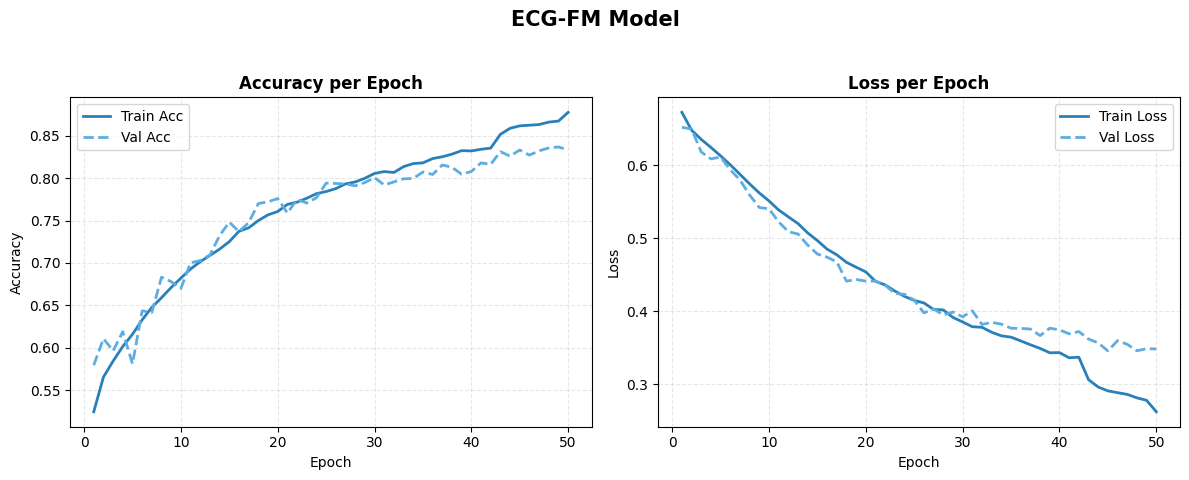

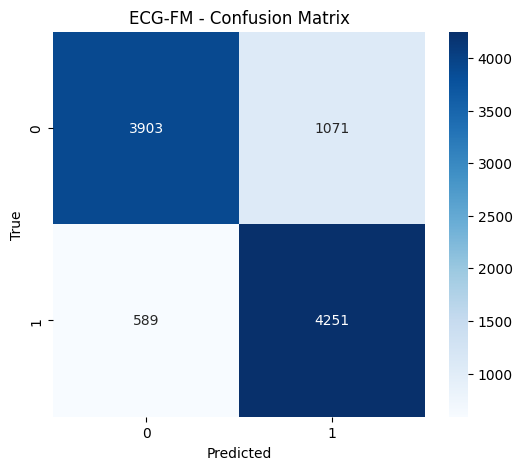


3️⃣ Training Adapter Model...
Trainable params: 165,312 / 870,082 (19.00%)

Epoch 1/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6832, Train Acc: 0.5169
Val Loss: 0.6670, Val Acc: 0.5030, F1: 0.6658

Epoch 2/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6615, Train Acc: 0.5507
Val Loss: 0.6403, Val Acc: 0.5863, F1: 0.6598

Epoch 3/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6468, Train Acc: 0.5715
Val Loss: 0.6302, Val Acc: 0.5801, F1: 0.6783

Epoch 4/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6370, Train Acc: 0.5856
Val Loss: 0.6197, Val Acc: 0.6017, F1: 0.6801

Epoch 5/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6287, Train Acc: 0.5989
Val Loss: 0.6118, Val Acc: 0.6207, F1: 0.6850

Epoch 6/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6219, Train Acc: 0.6036
Val Loss: 0.6015, Val Acc: 0.6205, F1: 0.6893

Epoch 7/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6154, Train Acc: 0.6112
Val Loss: 0.5958, Val Acc: 0.6347, F1: 0.6954

Epoch 8/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6108, Train Acc: 0.6227
Val Loss: 0.5907, Val Acc: 0.6246, F1: 0.7012

Epoch 9/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6044, Train Acc: 0.6289
Val Loss: 0.5846, Val Acc: 0.6437, F1: 0.7032

Epoch 10/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5990, Train Acc: 0.6334
Val Loss: 0.5808, Val Acc: 0.6267, F1: 0.7094

Epoch 11/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5939, Train Acc: 0.6375
Val Loss: 0.5759, Val Acc: 0.6508, F1: 0.7099

Epoch 12/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5882, Train Acc: 0.6454
Val Loss: 0.5697, Val Acc: 0.6691, F1: 0.7098

Epoch 13/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5857, Train Acc: 0.6480
Val Loss: 0.5696, Val Acc: 0.6583, F1: 0.7115

Epoch 14/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5839, Train Acc: 0.6510
Val Loss: 0.5578, Val Acc: 0.6717, F1: 0.7225

Epoch 15/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5749, Train Acc: 0.6613
Val Loss: 0.5544, Val Acc: 0.6727, F1: 0.7203

Epoch 16/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5744, Train Acc: 0.6593
Val Loss: 0.5571, Val Acc: 0.6850, F1: 0.7106

Epoch 17/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5695, Train Acc: 0.6647
Val Loss: 0.5466, Val Acc: 0.6757, F1: 0.7238

Epoch 18/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5664, Train Acc: 0.6659
Val Loss: 0.5405, Val Acc: 0.7018, F1: 0.7299

Epoch 19/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5657, Train Acc: 0.6703
Val Loss: 0.5443, Val Acc: 0.6721, F1: 0.7280

Epoch 20/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5612, Train Acc: 0.6717
Val Loss: 0.5350, Val Acc: 0.6986, F1: 0.7303

Epoch 21/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5590, Train Acc: 0.6766
Val Loss: 0.5294, Val Acc: 0.7000, F1: 0.7346

Epoch 22/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5556, Train Acc: 0.6765
Val Loss: 0.5432, Val Acc: 0.6668, F1: 0.7276

Epoch 23/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5527, Train Acc: 0.6794
Val Loss: 0.5267, Val Acc: 0.7043, F1: 0.7388

Epoch 24/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5508, Train Acc: 0.6833
Val Loss: 0.5335, Val Acc: 0.7140, F1: 0.7383

Epoch 25/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5479, Train Acc: 0.6851
Val Loss: 0.5229, Val Acc: 0.7017, F1: 0.7407

Epoch 26/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5474, Train Acc: 0.6850
Val Loss: 0.5240, Val Acc: 0.6915, F1: 0.7430

Epoch 27/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5463, Train Acc: 0.6860
Val Loss: 0.5270, Val Acc: 0.6933, F1: 0.7388

Epoch 28/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5431, Train Acc: 0.6885
Val Loss: 0.5298, Val Acc: 0.6921, F1: 0.7431

Epoch 29/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5416, Train Acc: 0.6869
Val Loss: 0.5310, Val Acc: 0.6689, F1: 0.7360

Epoch 30/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5298, Train Acc: 0.6965
Val Loss: 0.5071, Val Acc: 0.7198, F1: 0.7447

Epoch 31/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5294, Train Acc: 0.6987
Val Loss: 0.5079, Val Acc: 0.7067, F1: 0.7502

Epoch 32/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5273, Train Acc: 0.6991
Val Loss: 0.5015, Val Acc: 0.7187, F1: 0.7523

Epoch 33/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5268, Train Acc: 0.7011
Val Loss: 0.5057, Val Acc: 0.7125, F1: 0.7527

Epoch 34/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5264, Train Acc: 0.6994
Val Loss: 0.5012, Val Acc: 0.7136, F1: 0.7519

Epoch 35/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5223, Train Acc: 0.7017
Val Loss: 0.5001, Val Acc: 0.7092, F1: 0.7519

Epoch 36/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5220, Train Acc: 0.7030
Val Loss: 0.5064, Val Acc: 0.6996, F1: 0.7504

Epoch 37/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5226, Train Acc: 0.7032
Val Loss: 0.5021, Val Acc: 0.7054, F1: 0.7536

Epoch 38/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5199, Train Acc: 0.7061
Val Loss: 0.5012, Val Acc: 0.7300, F1: 0.7517

Epoch 39/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5180, Train Acc: 0.7060
Val Loss: 0.4960, Val Acc: 0.7183, F1: 0.7562

Epoch 40/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5173, Train Acc: 0.7056
Val Loss: 0.4922, Val Acc: 0.7176, F1: 0.7563

Epoch 41/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5143, Train Acc: 0.7115
Val Loss: 0.4924, Val Acc: 0.7315, F1: 0.7537

Epoch 42/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5131, Train Acc: 0.7134
Val Loss: 0.4910, Val Acc: 0.7219, F1: 0.7580

Epoch 43/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5142, Train Acc: 0.7123
Val Loss: 0.4919, Val Acc: 0.7203, F1: 0.7570

Epoch 44/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5138, Train Acc: 0.7117
Val Loss: 0.4950, Val Acc: 0.7132, F1: 0.7572

Epoch 45/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5111, Train Acc: 0.7124
Val Loss: 0.4928, Val Acc: 0.7213, F1: 0.7564

Epoch 46/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5107, Train Acc: 0.7129
Val Loss: 0.4866, Val Acc: 0.7334, F1: 0.7598

Epoch 47/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5108, Train Acc: 0.7109
Val Loss: 0.4897, Val Acc: 0.7211, F1: 0.7596

Epoch 48/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5085, Train Acc: 0.7159
Val Loss: 0.4840, Val Acc: 0.7318, F1: 0.7622

Epoch 49/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5094, Train Acc: 0.7124
Val Loss: 0.4870, Val Acc: 0.7172, F1: 0.7600

Epoch 50/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5081, Train Acc: 0.7169
Val Loss: 0.4852, Val Acc: 0.7375, F1: 0.7656

Evaluating Adapter Model...


Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

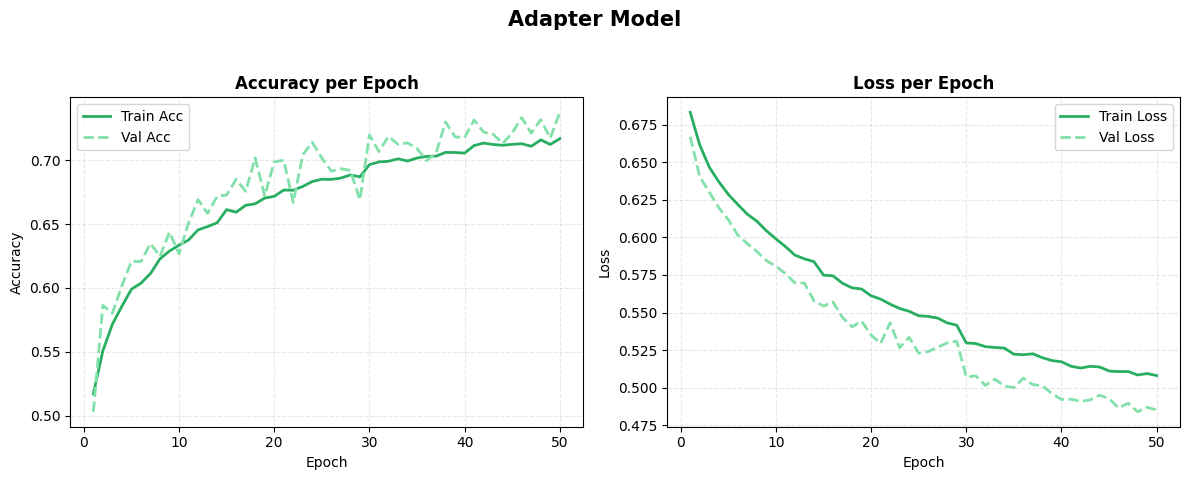

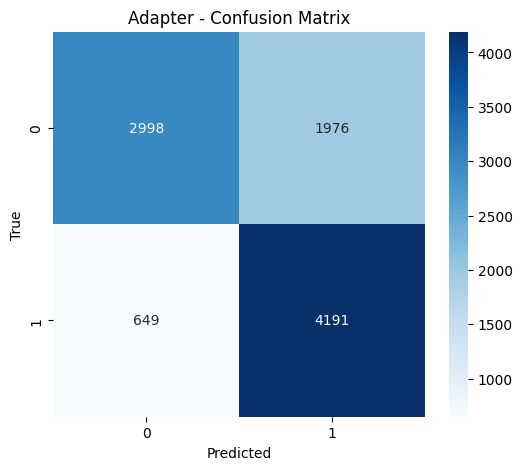


4️⃣ Training LoRA Model...

Epoch 1/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6777, Train Acc: 0.5140
Val Loss: 0.6581, Val Acc: 0.5018, F1: 0.6613

Epoch 2/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6637, Train Acc: 0.5305
Val Loss: 0.6571, Val Acc: 0.5043, F1: 0.6614

Epoch 3/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6590, Train Acc: 0.5470
Val Loss: 0.6551, Val Acc: 0.5778, F1: 0.6364

Epoch 4/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6547, Train Acc: 0.5586
Val Loss: 0.6515, Val Acc: 0.5424, F1: 0.6441

Epoch 5/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6553, Train Acc: 0.5559
Val Loss: 0.6475, Val Acc: 0.6077, F1: 0.5907

Epoch 6/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6485, Train Acc: 0.5733
Val Loss: 0.6490, Val Acc: 0.5826, F1: 0.6324

Epoch 7/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6443, Train Acc: 0.5841
Val Loss: 0.6410, Val Acc: 0.5548, F1: 0.6539

Epoch 8/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6434, Train Acc: 0.5892
Val Loss: 0.6417, Val Acc: 0.5850, F1: 0.6467

Epoch 9/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6407, Train Acc: 0.5855
Val Loss: 0.6424, Val Acc: 0.5856, F1: 0.6538

Epoch 10/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6390, Train Acc: 0.5887
Val Loss: 0.6417, Val Acc: 0.6029, F1: 0.6171

Epoch 11/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6367, Train Acc: 0.5916
Val Loss: 0.6423, Val Acc: 0.5558, F1: 0.6553

Epoch 12/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6279, Train Acc: 0.6021
Val Loss: 0.6306, Val Acc: 0.5994, F1: 0.6490

Epoch 13/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6242, Train Acc: 0.6057
Val Loss: 0.6255, Val Acc: 0.5891, F1: 0.6660

Epoch 14/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6206, Train Acc: 0.6080
Val Loss: 0.6214, Val Acc: 0.6305, F1: 0.6416

Epoch 15/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6173, Train Acc: 0.6172
Val Loss: 0.6166, Val Acc: 0.6318, F1: 0.6571

Epoch 16/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6135, Train Acc: 0.6168
Val Loss: 0.6091, Val Acc: 0.6274, F1: 0.6585

Epoch 17/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6087, Train Acc: 0.6217
Val Loss: 0.6065, Val Acc: 0.6321, F1: 0.6651

Epoch 18/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.6041, Train Acc: 0.6277
Val Loss: 0.6001, Val Acc: 0.6304, F1: 0.6794

Epoch 19/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5984, Train Acc: 0.6322
Val Loss: 0.5978, Val Acc: 0.6390, F1: 0.6810

Epoch 20/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5940, Train Acc: 0.6366
Val Loss: 0.5874, Val Acc: 0.6396, F1: 0.6949

Epoch 21/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5867, Train Acc: 0.6431
Val Loss: 0.5833, Val Acc: 0.6377, F1: 0.7014

Epoch 22/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5818, Train Acc: 0.6515
Val Loss: 0.5812, Val Acc: 0.6457, F1: 0.7108

Epoch 23/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5753, Train Acc: 0.6539
Val Loss: 0.5717, Val Acc: 0.6615, F1: 0.7056

Epoch 24/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5700, Train Acc: 0.6628
Val Loss: 0.5631, Val Acc: 0.6724, F1: 0.7131

Epoch 25/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5667, Train Acc: 0.6637
Val Loss: 0.5518, Val Acc: 0.6793, F1: 0.7214

Epoch 26/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5623, Train Acc: 0.6684
Val Loss: 0.5529, Val Acc: 0.6849, F1: 0.7181

Epoch 27/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5545, Train Acc: 0.6765
Val Loss: 0.5393, Val Acc: 0.6927, F1: 0.7282

Epoch 28/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5485, Train Acc: 0.6845
Val Loss: 0.5388, Val Acc: 0.6983, F1: 0.7246

Epoch 29/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5399, Train Acc: 0.6919
Val Loss: 0.5266, Val Acc: 0.7157, F1: 0.7294

Epoch 30/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5389, Train Acc: 0.6947
Val Loss: 0.5248, Val Acc: 0.7144, F1: 0.7386

Epoch 31/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5327, Train Acc: 0.6997
Val Loss: 0.5188, Val Acc: 0.7152, F1: 0.7409

Epoch 32/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5296, Train Acc: 0.7029
Val Loss: 0.5153, Val Acc: 0.7280, F1: 0.7467

Epoch 33/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5217, Train Acc: 0.7128
Val Loss: 0.5072, Val Acc: 0.7323, F1: 0.7532

Epoch 34/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5201, Train Acc: 0.7143
Val Loss: 0.5090, Val Acc: 0.7416, F1: 0.7564

Epoch 35/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5144, Train Acc: 0.7155
Val Loss: 0.5074, Val Acc: 0.7415, F1: 0.7447

Epoch 36/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5098, Train Acc: 0.7224
Val Loss: 0.4971, Val Acc: 0.7190, F1: 0.7578

Epoch 37/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5075, Train Acc: 0.7220
Val Loss: 0.4886, Val Acc: 0.7284, F1: 0.7658

Epoch 38/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.5002, Train Acc: 0.7308
Val Loss: 0.4787, Val Acc: 0.7367, F1: 0.7673

Epoch 39/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4973, Train Acc: 0.7334
Val Loss: 0.4794, Val Acc: 0.7486, F1: 0.7673

Epoch 40/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4917, Train Acc: 0.7363
Val Loss: 0.4815, Val Acc: 0.7240, F1: 0.7664

Epoch 41/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4918, Train Acc: 0.7382
Val Loss: 0.4757, Val Acc: 0.7396, F1: 0.7703

Epoch 42/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4856, Train Acc: 0.7420
Val Loss: 0.4610, Val Acc: 0.7631, F1: 0.7779

Epoch 43/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4844, Train Acc: 0.7430
Val Loss: 0.4613, Val Acc: 0.7623, F1: 0.7765

Epoch 44/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4793, Train Acc: 0.7468
Val Loss: 0.4520, Val Acc: 0.7675, F1: 0.7869

Epoch 45/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4775, Train Acc: 0.7477
Val Loss: 0.4590, Val Acc: 0.7693, F1: 0.7797

Epoch 46/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4705, Train Acc: 0.7521
Val Loss: 0.4500, Val Acc: 0.7647, F1: 0.7800

Epoch 47/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4709, Train Acc: 0.7553
Val Loss: 0.4544, Val Acc: 0.7580, F1: 0.7797

Epoch 48/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4669, Train Acc: 0.7546
Val Loss: 0.4594, Val Acc: 0.7743, F1: 0.7728

Epoch 49/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4654, Train Acc: 0.7557
Val Loss: 0.4428, Val Acc: 0.7719, F1: 0.7906

Epoch 50/50


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

Train Loss: 0.4638, Train Acc: 0.7572
Val Loss: 0.4617, Val Acc: 0.7572, F1: 0.7797

Evaluating LoRA Model...


Evaluating:   0%|          | 0/77 [00:00<?, ?it/s]

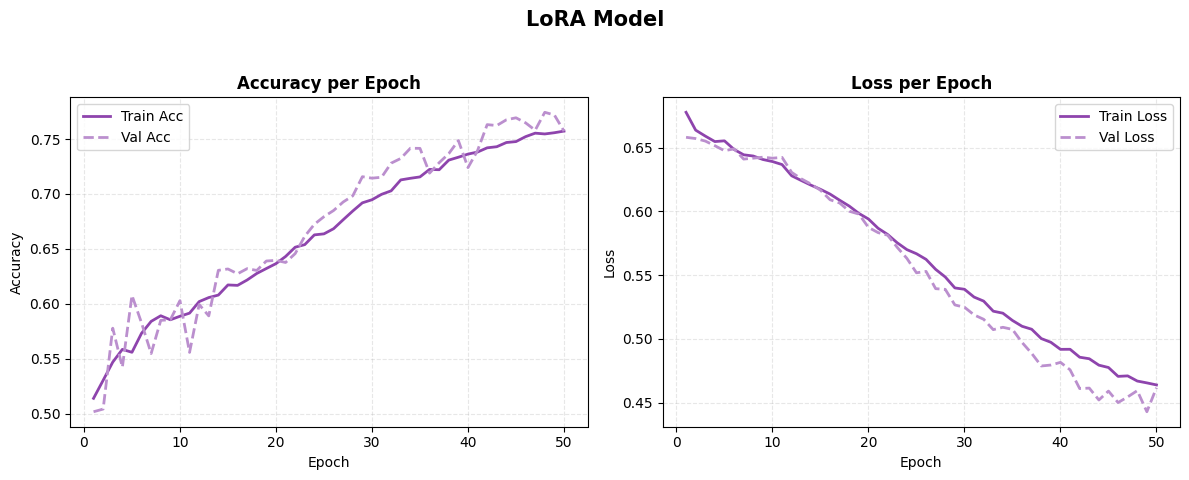

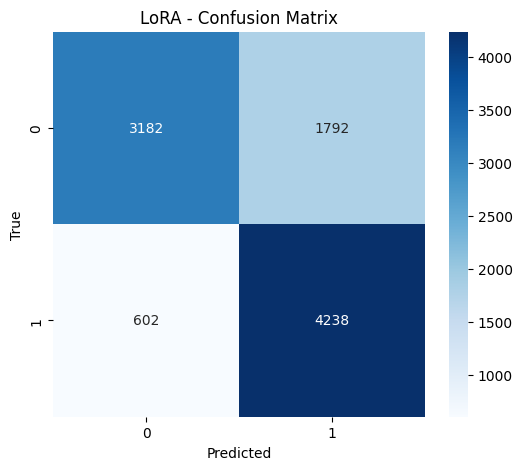


5️⃣ Final Results Comparison
 Method  Epochs  Learning Rate  Accuracy  Precision   Recall  F1-Score Trainable %
 ECG-FM      50         0.0010  0.830854   0.798760 0.878306  0.836646        100%
Adapter      50         0.0015  0.732525   0.679585 0.865909  0.761515       5.66%
   LoRA      50         0.0025  0.756063   0.702819 0.875620  0.779761       3.26%


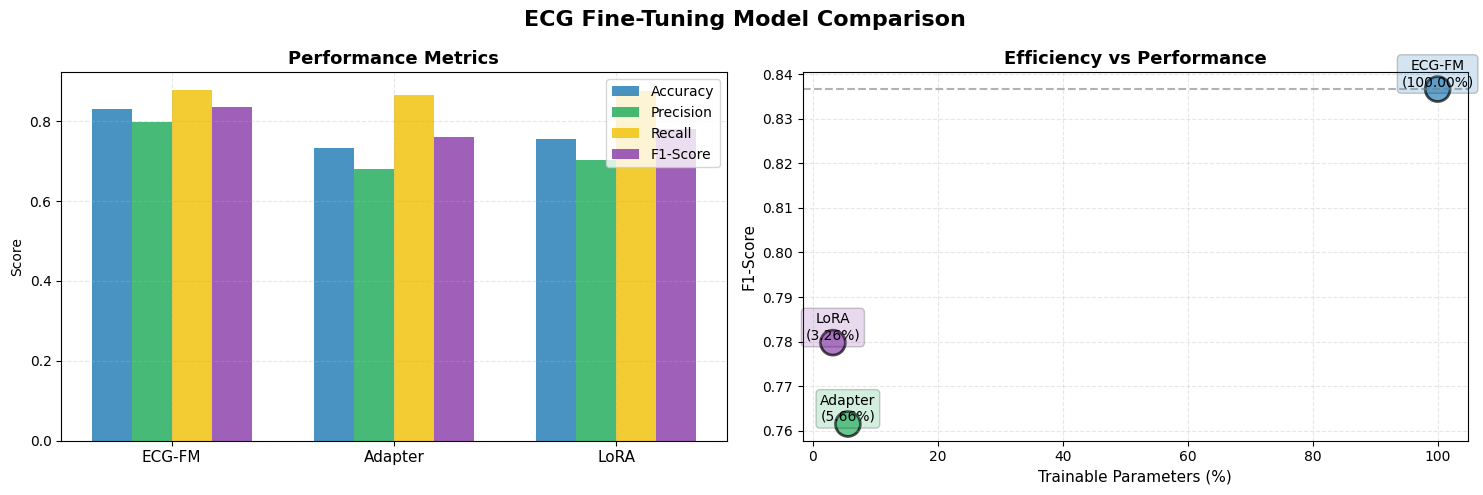

In [25]:
# MAIN EXECUTION - ECG FINE-TUNING (ECG-FM, LoRA, Adapter)


def main():
    """Main function to execute ECG fine-tuning experiments"""

    # -----------------------------
    # Configuration
    # -----------------------------
    FILE_PATH = '/kaggle/input/segment/df_segment2.csv'
    CHECKPOINT_PATH = '/kaggle/input/mimic_iv_ecg_physionet_pretrained.pt'

    

    BATCH_SIZE = 128
    NUM_EPOCHS = 50

    # Learning rates
    LR_ECGFM = 1e-3
    LR_ADAPTER = 1.5e-3
    LR_LORA = 2.5e-3

    # LoRA hyperparameters
    LORA_R = 48
    LORA_ALPHA = 96
    LORA_DROPOUT = 0.05

    # Adapter hyperparameters
    ADAPTER_REDUCTION = 4

    # Class weights
    USE_CLASS_WEIGHTS = True
    CLASS_WEIGHT_POSITIVE = 1.4

    print(f"Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}")
    print(f"Class Weights: {'Enabled' if USE_CLASS_WEIGHTS else 'Disabled'} "
          f"[1.0, {CLASS_WEIGHT_POSITIVE}]")
    print(f"Learning Rates -> ECG-FM: {LR_ECGFM}, Adapter: {LR_ADAPTER}, LoRA: {LR_LORA}")
    print(f"LoRA -> r: {LORA_R}, alpha: {LORA_ALPHA}, dropout: {LORA_DROPOUT}")
    print(f"Adapter -> reduction_factor: {ADAPTER_REDUCTION}")

    # -----------------------------
    # Load and preprocess data
    # -----------------------------
    print("\n1️⃣ Loading and preprocessing data...")
    data = prepare_ecg_data(FILE_PATH, normalization='per_sample')

    train_loader = DataLoader(ECGDataset(*data['train']), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(ECGDataset(*data['val']), batch_size=BATCH_SIZE)
    test_loader  = DataLoader(ECGDataset(*data['test']), batch_size=BATCH_SIZE)

    results = {}

    # -----------------------------
    # 1️⃣ ECG-FM Model
    # -----------------------------
    print("\n2️⃣ Training ECG-FM Model...")
    ecgfm_model = ECGFMClassifier(input_dim=600, hidden_dim=256, num_classes=2)
    ecgfm_model, ecgfm_history = train_model_with_weights(
        ecgfm_model, train_loader, val_loader,
        NUM_EPOCHS, LR_ECGFM, device,
        use_class_weights=USE_CLASS_WEIGHTS,
        class_weight_positive=CLASS_WEIGHT_POSITIVE
    )

    print("\nEvaluating ECG-FM Model...")
    ecgfm_results = evaluate(ecgfm_model, test_loader, nn.CrossEntropyLoss(), device)
    results['ECG-FM'] = ecgfm_results

    plot_training_history(ecgfm_history, "ECG-FM Model", color_scheme='Blues')
    plot_confusion_matrix(ecgfm_results['labels'], ecgfm_results['predictions'], "ECG-FM - Confusion Matrix")

    # -----------------------------
    # 2️⃣ Adapter Model
    # -----------------------------
    print("\n3️⃣ Training Adapter Model...")
    base_adapter = ECGFMClassifier(input_dim=600, hidden_dim=256, num_classes=2)

    adapter_model = create_model_with_adapter(base_adapter, reduction_factor=ADAPTER_REDUCTION)
    adapter_model, adapter_history = train_model_with_weights(
        adapter_model, train_loader, val_loader,
        NUM_EPOCHS, LR_ADAPTER, device,
        use_class_weights=USE_CLASS_WEIGHTS,
        class_weight_positive=CLASS_WEIGHT_POSITIVE
    )

    print("\nEvaluating Adapter Model...")
    adapter_results = evaluate(adapter_model, test_loader, nn.CrossEntropyLoss(), device)
    results['Adapter'] = adapter_results

    plot_training_history(adapter_history, "Adapter Model", color_scheme='Greens')
    plot_confusion_matrix(adapter_results['labels'], adapter_results['predictions'], "Adapter - Confusion Matrix")

    # -----------------------------
    # 3️⃣ LoRA Model
    # -----------------------------
    print("\n4️⃣ Training LoRA Model...")
    base_lora = ECGFMClassifier(input_dim=600, hidden_dim=256, num_classes=2)
    lora_model = create_model_with_lora(base_lora, r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT)
    lora_model, lora_history = train_model_with_weights(
        lora_model, train_loader, val_loader,
        NUM_EPOCHS, LR_LORA, device,
        use_class_weights=USE_CLASS_WEIGHTS,
        class_weight_positive=CLASS_WEIGHT_POSITIVE
    )

    print("\nEvaluating LoRA Model...")
    lora_results = evaluate(lora_model, test_loader, nn.CrossEntropyLoss(), device)
    results['LoRA'] = lora_results

    plot_training_history(lora_history, "LoRA Model", color_scheme='Purples')
    plot_confusion_matrix(lora_results['labels'], lora_results['predictions'], "LoRA - Confusion Matrix")

    # -----------------------------
    # Results Comparison
    # -----------------------------
    print("\n5️⃣ Final Results Comparison")
    print("="*90)

    comparison_df = pd.DataFrame({
        'Method': ['ECG-FM', 'Adapter', 'LoRA'],
        'Epochs': [NUM_EPOCHS] * 3,
        'Learning Rate': [LR_ECGFM, LR_ADAPTER, LR_LORA],
        'Accuracy': [results[m]['accuracy'] for m in ['ECG-FM', 'Adapter', 'LoRA']],
        'Precision': [results[m]['precision'] for m in ['ECG-FM', 'Adapter', 'LoRA']],
        'Recall': [results[m]['recall'] for m in ['ECG-FM', 'Adapter', 'LoRA']],
        'F1-Score': [results[m]['f1'] for m in ['ECG-FM', 'Adapter', 'LoRA']],
        'Trainable %': ['100%', '5.66%', '3.26%']
    })

    print(comparison_df.to_string(index=False))

    # -----------------------------
    # Visualization: Comparison Overview
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("ECG Fine-Tuning Model Comparison", fontsize=16, fontweight='bold')

    # Bar chart - metrics
    x = np.arange(len(comparison_df))
    width = 0.18
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#2980B9', '#27AE60', '#F1C40F', '#8E44AD']

    for i, metric in enumerate(metrics):
        axes[0].bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i], alpha=0.85)

    axes[0].set_xticks(x + width*1.5)
    axes[0].set_xticklabels(comparison_df['Method'], fontsize=11)
    axes[0].set_ylabel('Score')
    axes[0].set_title('Performance Metrics', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3, linestyle='--')

    # Scatter chart - parameter efficiency
    methods = comparison_df['Method']
    f1_scores = comparison_df['F1-Score']
    trainable_pct = [100, 5.66, 3.26]
    color_map = {'ECG-FM': '#2980B9', 'Adapter': '#27AE60', 'LoRA': '#8E44AD'}

    scatter_colors = [color_map[m] for m in methods]
    axes[1].scatter(trainable_pct, f1_scores, s=320, c=scatter_colors, alpha=0.7, edgecolors='black', linewidth=2)

    for i, m in enumerate(methods):
        axes[1].annotate(f'{m}\n({trainable_pct[i]:.2f}%)',
                         (trainable_pct[i], f1_scores[i]),
                         fontsize=10, ha='center', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor=scatter_colors[i], alpha=0.2))

    axes[1].axhline(y=f1_scores[0], color='gray', linestyle='--', alpha=0.6)
    axes[1].set_xlabel('Trainable Parameters (%)', fontsize=11)
    axes[1].set_ylabel('F1-Score', fontsize=11)
    axes[1].set_title('Efficiency vs Performance', fontsize=13, fontweight='bold')
    axes[1].grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

    return results, comparison_df


# Run main
if __name__ == "__main__":
    results, comparison_df = main()

